In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dt_apriltags import Detector

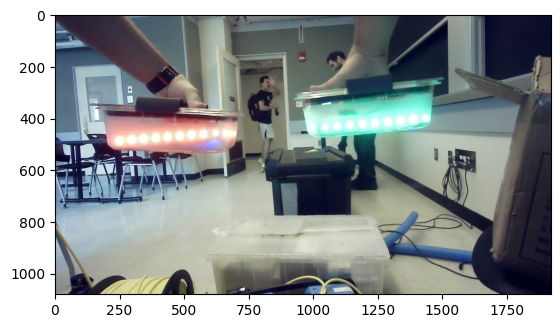

In [2]:
img = cv2.imread('image.jpg')
plt.imshow(img)

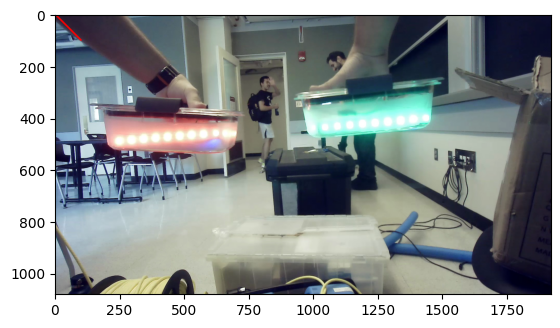

In [3]:
cv2.line(img, (0, 0), (100, 100), (255, 0, 0), 5)
plt.imshow(img)

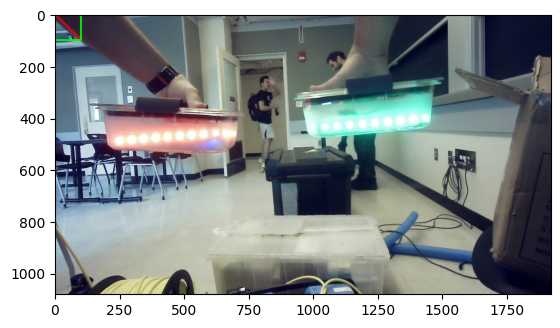

In [4]:
cv2.rectangle(img, (0, 0), (100, 100), (0, 255, 0), 5)
plt.imshow(img)

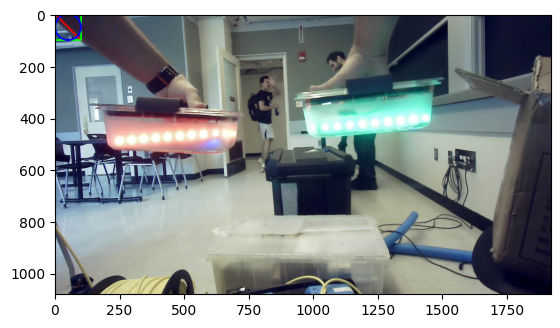

In [5]:
cv2.circle(img, (50, 50), 50, (0, 0, 255), 5)
plt.imshow(img)

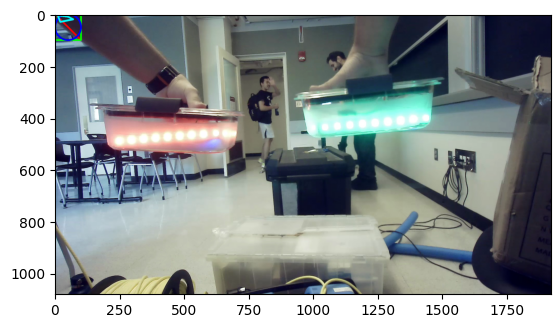

In [6]:
pts = np.array([[10, 5], [20, 30], [70, 20], [50, 10]], np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.polylines(img, [pts], True, (0, 255, 255), 5)
plt.imshow(img)

In [16]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
edges = cv2.Canny(gray, 50, 150, apertureSize=7) # detect edges
lines = cv2.HoughLinesP(
                edges,
                1,
                np.pi/180,
                100,
                minLineLength=100,
                maxLineGap=10,
        ) # detect lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(img)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


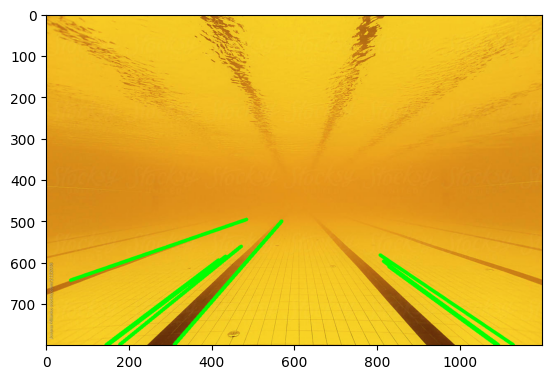

In [31]:
img = cv2.imread("pool2.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
edges = cv2.Canny(gray, 50, 200, apertureSize=7) # detect edges
# plt.imshow(edges)
lines = cv2.HoughLinesP(
                edges,
                1,
                np.pi/180,
                500,
                minLineLength=250,
                maxLineGap=5,
        ) # detect lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 7)

plt.imshow(img)

[[148.07374573 109.20044708]
 [167.49220276 108.4158783 ]
 [153.30262756  89.62454987]
 [132.03965759  90.17698669]]
[[451.37316895  91.40827179]
 [470.70095825  90.44836426]
 [482.58377075  72.19226074]
 [462.41769409  73.33588409]]
[[554.31921387 388.7227478 ]
 [546.09033203 358.20751953]
 [519.23352051 359.99130249]
 [528.7734375  392.51019287]]
[[310.40652466 106.50978088]
 [328.24972534 105.81019592]
 [327.72503662  92.35285187]
 [310.04534912  92.81846619]]
[[194.28860474 307.61105347]
 [169.14706421 308.99703979]
 [163.6441803  337.43667603]
 [190.05665588 335.90756226]]


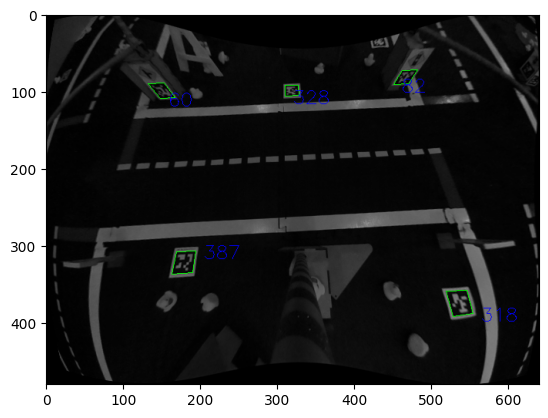

In [9]:
"""
- Run the code above and make sure it works.
Done!
- What do the parameters of the Detector function do?
The parameters determine how the detector searches for april tags, including the number of threads to use and the
resolution to search by.
- What happens if you change the parameters?
It largely affects the time it takes to find the april tags, and the accuracy with which it can. 
- What are families?
families are the types of tags to look for.
- What does estimate_tag_pose do?
Not sure.
- What does camera_params do?
Adjusts the expected camera focal length and position.
- What does tag_size do?
The expected size of the tag in meters.
- The detect function returns a list of tags. What information does each tag contain?
Each tag has the tag family, the tag ID, the decision margin or confidence in location, and a description of the tag's geometry.
- Modify the code to give the position and orientation of each tag.

"""
img = cv2.imread('test_image.png', cv2.IMREAD_GRAYSCALE)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)
tags = at_detector.detect(img, estimate_tag_pose=False, camera_params=None, tag_size=None)
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for tag in tags:
    print(tag.corners)
    for idx in range(len(tag.corners)):
        cv2.line(color_img, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0))

    cv2.putText(color_img, str(tag.tag_id),
                org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.8,
                color=(0, 0, 255))
    
plt.imshow(color_img)

In [24]:
vcap = cv2.VideoCapture("rtsp://10.29.17.108:8554/test")
ret, frame = vcap.read()
plt.savefig("rov_photo.png")
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

[rtsp @ 0x17934780] method DESCRIBE failed: 503 Service Unavailable
[ERROR:0@497.865] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): rtsp://10.29.17.108:8554/test in function 'icvExtractPattern'




error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<Figure size 640x480 with 0 Axes>

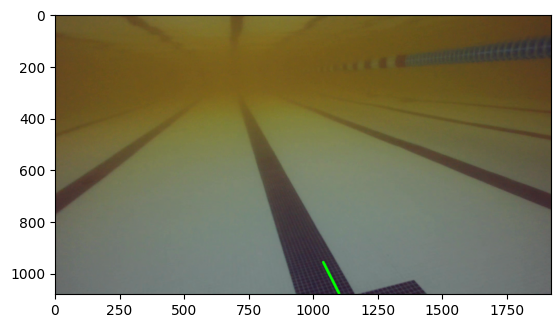

In [49]:
img = cv2.imread("rov_pool.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
edges = cv2.Canny(gray, 50, 150, apertureSize=7) # detect edges
# plt.imshow(edges)
lines = cv2.HoughLinesP(
                edges,
                1,
                np.pi/180,
                100,
                minLineLength=100,
                maxLineGap=3,
        ) # detect lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)

plt.imshow(img)